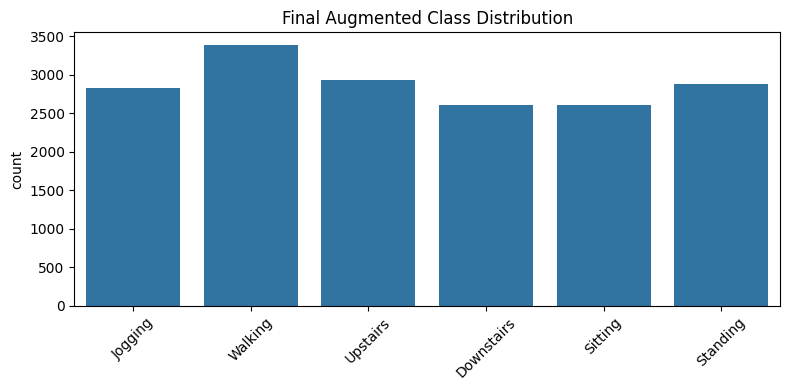

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: simple jittering function for augmentation
def add_jitter(X, sigma=0.01):
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise

# Load the dataset
data = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\HAR-WISDM\Data_WISDM\WISDM_cleaned.csv")

# Separate features and target
X = data.drop('class', axis=1)
y = data['class']

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for CNN-LSTM: assuming 30 features = (10 time steps × 3 features)
X_reshaped = X_scaled.reshape(-1, 10, 3)
y_reshaped = y_encoded.reshape(-1)

# === 1. Augment Downstairs, Upstairs, Standing using factor ===
def augment_minority_classes(X, y, classes_to_augment, augment_func, augment_factor=2):
    X_augmented = []
    y_augmented = []

    for cls in classes_to_augment:
        X_cls = X[y == cls]
        for _ in range(augment_factor):
            X_augmented.append(augment_func(X_cls))
            y_augmented.append(np.full(len(X_cls), cls))

    X_aug = np.concatenate(X_augmented, axis=0)
    y_aug = np.concatenate(y_augmented, axis=0)

    X_new = np.concatenate([X, X_aug], axis=0)
    y_new = np.concatenate([y, y_aug], axis=0)

    return X_new, y_new

classes_to_augment = []
for class_name in ['Downstairs', 'Upstairs', 'Standing']:
    cls_idx = label_encoder.transform([class_name])[0]
    classes_to_augment.append(cls_idx)

X_temp, y_temp = augment_minority_classes(X_reshaped, y_reshaped, classes_to_augment, add_jitter, augment_factor=3)

# === 2. Augment Jogging (400) and Walking (200) specifically ===
def augment_specific_classes(X, y, class_sample_map, augment_func):
    X_augmented = []
    y_augmented = []

    for cls, n_samples in class_sample_map.items():
        X_cls = X[y == cls]
        sampled_indices = np.random.choice(len(X_cls), size=n_samples, replace=True)
        X_sampled = X_cls[sampled_indices]
        X_aug = augment_func(X_sampled)
        X_augmented.append(X_aug)
        y_augmented.append(np.full(n_samples, cls))

    X_new = np.concatenate([X] + X_augmented, axis=0)
    y_new = np.concatenate([y] + y_augmented, axis=0)

    return X_new, y_new

# Define how many samples to add per class
class_sample_map = {}
for class_name, n_samples in [('Jogging', 1200), ('Walking',1300),('Sitting', 2300), ('Standing',1900), ('Downstairs', 500), ('Upstairs',400)]:
    cls_idx = label_encoder.transform([class_name])[0]
    class_sample_map[cls_idx] = n_samples

# Apply the specific class augmentation
X_augmented, y_augmented = augment_specific_classes(X_temp, y_temp, class_sample_map, add_jitter)

# === Compute class weights ===
class_weights_aug = compute_class_weight('balanced', classes=np.unique(y_augmented), y=y_augmented)
class_weight_dict_aug = dict(enumerate(class_weights_aug))

# === Visualize final class distribution ===
plt.figure(figsize=(8, 4))
sns.countplot(x=label_encoder.inverse_transform(y_augmented))
plt.title('Final Augmented Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# You can now use: X_augmented, y_augmented, class_weight_dict_aug in training


In [7]:
# === REPLACE your old training script with this one ===

# Build CNN-LSTM with residual connections
def build_cnn_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # CNN Block 1
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Residual Connection
    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.2)(x)
    
    # CNN Block 2
    x = Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # LSTM Layer
    x = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    
    # Dense Layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
f1_scores = []

for train_idx, val_idx in skf.split(X_augmented, y_augmented):
    print(f"\n📚 Training Fold {fold}")
    X_train, X_val = X_augmented[train_idx], X_augmented[val_idx]
    y_train, y_val = y_augmented[train_idx], y_augmented[val_idx]
    
    # Optional: light data augmentation on training data (e.g., jittering)
    # X_train = add_jitter(X_train, sigma=0.02)

    model = build_cnn_lstm_model(input_shape=(10, 3), num_classes=len(np.unique(y_augmented)))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        class_weight=class_weight_dict_aug,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    
    # Evaluate model
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print(f"\n🧾 Fold {fold} Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))
    
    # Store macro F1-score
    report = classification_report(y_val, y_pred_classes, output_dict=True)
    f1_scores.append(report['macro avg']['f1-score'])
    fold += 1

# Final macro F1 score across folds
print(f"\n✅ Average Macro F1-Score across {skf.n_splits} folds: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



📚 Training Fold 1
Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4288 - loss: 3.8531 - val_accuracy: 0.4806 - val_loss: 1.6459 - learning_rate: 0.0010
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5407 - loss: 1.3204 - val_accuracy: 0.5789 - val_loss: 1.1467 - learning_rate: 0.0010
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5747 - loss: 1.1319 - val_accuracy: 0.5757 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5902 - loss: 1.0936 - val_accuracy: 0.6111 - val_loss: 1.0550 - learning_rate: 0.0010
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6114 - loss: 1.0494 - val_accuracy: 0.6386 - val_loss: 1.0080 - learning_rate: 0.0010
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6115 - loss: 1.0437 - val_accuracy: 0.5960 - val_loss: 1.0947 - learning_rate: 0.0010
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - a

In [3]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │      1,024 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 10, 64)    │     20,544 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 64)    │          0 │ dropout_20[0][0], │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 10, 64)    │          0 │ add_4[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 128)   │     41,088 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 128)       │    131,584 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 128)       │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 6)         │        774 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 636,628 (2.43 MB)

 Trainable params: 212,038 (828.27 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 424,078 (1.62 MB)

In [9]:
# Save the entire model (architecture + weights + optimizer state)
model.save('HAR.keras')


c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 21 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.9440753045404208

Classification Report:

              precision    recall  f1-score   support

  Downstairs       0.86      1.00      0.92       528
     Jogging       0.97      0.93      0.95      1625
     Sitting       1.00      1.00      1.00       306
    Standing       0.98      1.00      0.99       246
    Upstairs       0.87      0.99      0.93       632
     Walking       0.96      0.91      0.94      2081

    accuracy                           0.94      5418
   macro avg       0.94      0.97      0.95      5418
weighted avg       0.95      0.94      0.94      5418



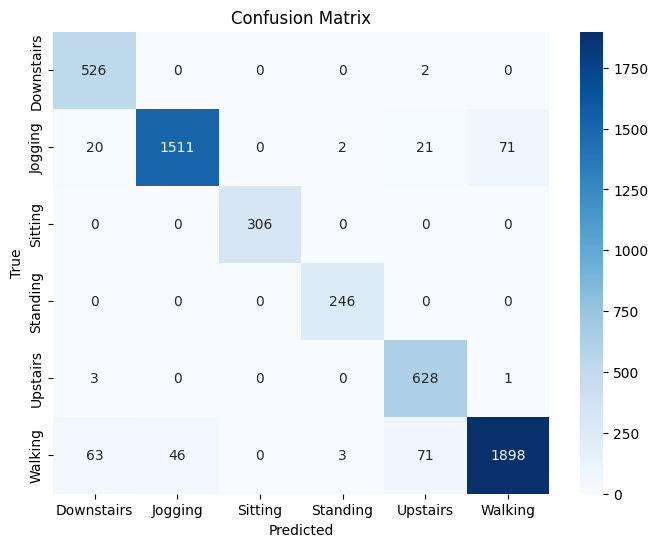

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model

# === Load your original dataset (without augmentation) ===
data = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\HAR-WISDM\Data_WISDM\WISDM_cleaned.csv")

# === Prepare X and y ===
X = data.drop('class', axis=1)
y = data['class']

# Label encoding for y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN-LSTM input (assuming 10 time steps × 3 features)
X_reshaped = X_scaled.reshape(-1, 10, 3)

# === Load your saved model ===
model = load_model(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\HAR-WISDM\HAR.keras')  # <-- replace with your saved model path

# === Predict ===
y_pred_probs = model.predict(X_reshaped)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# === Metrics ===
print("Accuracy:", accuracy_score(y_encoded, y_pred_classes))
print("\nClassification Report:\n")
print(classification_report(y_encoded, y_pred_classes, target_names=label_encoder.classes_))

# Optional: Confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
